In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import math
import numpy as np
from PIL import Image

In [2]:
##############
# step 1: mosaicing
##############

# read images
img_in = Image.open('data/porto1.png').convert('RGB')
img_ref = Image.open('data/porto2.png').convert('RGB')

# shape of igs_in, igs_ref: [y, x, 3]
igs_in = np.array(img_in)
igs_ref = np.array(img_ref)

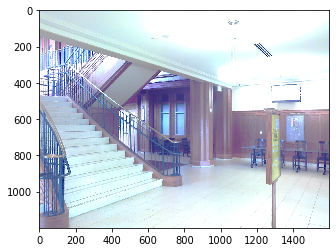

In [3]:
igs_in_img = Image.fromarray(igs_in.astype(np.uint8))
imshow(igs_in_img)

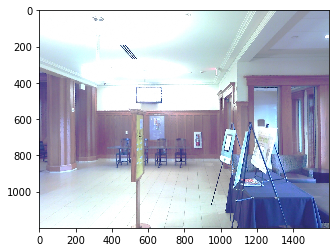

In [4]:
igs_ref_img = Image.fromarray(igs_ref.astype(np.uint8))
imshow(igs_ref_img)

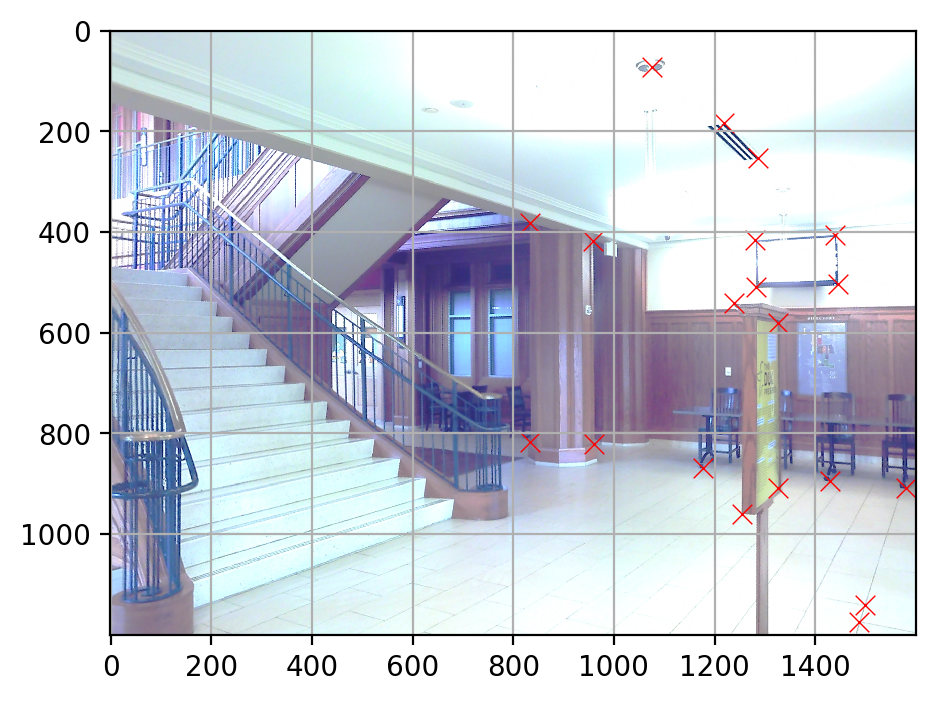

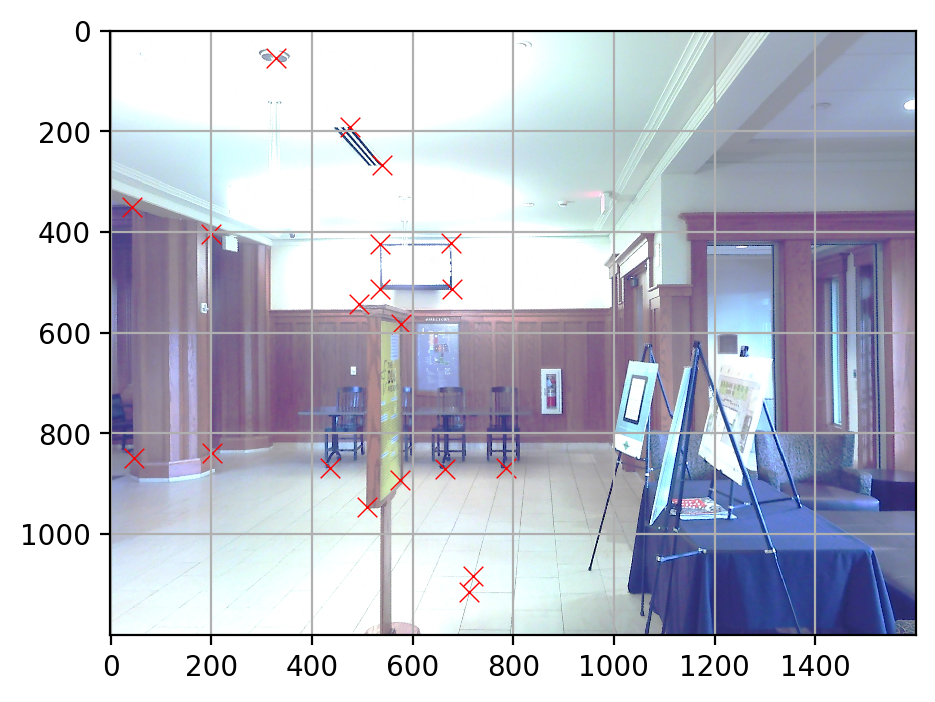

((20, 2), (20, 2))

In [14]:
def set_cor_mosaic():
    # pixel_x and pixel_y
    
    p_in = np.array([[958, 417],
                    [961, 821],
                    [1239, 541],
                    [1254, 959],
                    [1327, 909],
                    [1326, 580],
                    [1445, 504],
                    [1440, 405],
                    [1281, 416],
                    [1283, 509],
                    [1178, 869],
                    [1429, 895],
                    [1581, 908],
                    [1498, 1140],
                    [1487, 1174],
                    [833, 382],
                    [834, 817],
                    [1219, 183],
                    [1287, 253],
                    [1075, 72]])
    
    p_ref = np.array([[199, 403],
                    [202, 839],
                    [493, 542],
                    [509, 947],
                    [576, 893],
                    [577, 583],
                    [679, 513],
                    [677, 422],
                    [535, 424],
                    [536, 513],
                    [435, 868],
                    [665, 870],
                    [786, 869],
                    [720, 1084],
                    [713, 1115],
                    [43, 351],
                    [46, 848],
                    [476, 191],
                    [539, 267],
                    [329, 54]])
    
    plt.figure(dpi=200)
    plt.grid(True)
    plt.scatter(p_in[:,0], p_in[:,1], marker='x', c='red', s=50, linewidth=0.5)
    plt.imshow(igs_in_img)
    plt.show()
    
    plt.figure(dpi=200)
    plt.grid(True)
    plt.scatter(p_ref[:,0], p_ref[:,1], marker='x', c='red', s=50, linewidth=0.5)
    plt.imshow(igs_ref_img)
    plt.show()
    
    return p_in, p_ref

# lists of the corresponding points (x,y)
# shape of p_in, p_ref: [N, 2]
p_in, p_ref = set_cor_mosaic()
p_in.shape, p_ref.shape

In [15]:
import cv2
def compute_h(p1, p2):
    # SVD of A such that p1 = A p2
    assert(p1.shape == p2.shape)
    N = p1.shape[0]
    A = np.zeros((2*N, 9))
    for i in range(N):
        x1, y1 = p1[i]
        x2, y2 = p2[i]
        A[i*2:i*2+2,:] = np.array([[x2, y2, 1, 0, 0, 0, -x2*x1, -y2*x1, -x1],
                                   [0, 0, 0, x2, y2, 1, -x2*y1, -y2*y1, -y1]])

    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    return H

def compute_h_norm(p1, p2):
    # Nomalize H
    y_max, x_max = np.max([np.max(p1, axis=0), np.max(p2, axis=0)], axis=0)
    H = compute_h(p1 / (y_max, x_max), p2 / (y_max, x_max))
    
    H = H / np.sqrt(np.sum(H**2))
    H[0,:] *= y_max
    H[1,:] *= x_max
    H[:,0] /= y_max
    H[:,1] /= x_max
    
    return H / H[-1,-1]

h, status = cv2.findHomography(p_in, p_ref)
print(h)
print(np.matmul(h, np.array([0, 0, 1]).transpose()))

# p_ref = H * p_in
H = compute_h_norm(p_ref, p_in)
print(H)
print(np.matmul(H, np.array([0, 0, 1]).transpose()))

[[ 1.97396472e+00  1.67530656e-03 -1.57868350e+03]
 [ 3.63413455e-01  1.71448091e+00 -4.25789285e+02]
 [ 6.05287375e-04  6.27554347e-06  1.00000000e+00]]
[-1.57868350e+03 -4.25789285e+02  1.00000000e+00]
[[ 1.98492451e+00  9.79331936e-04 -1.58762678e+03]
 [ 3.68247244e-01  1.72144412e+00 -4.31093486e+02]
 [ 6.12593114e-04  4.81123758e-06  1.00000000e+00]]
[-1.58762678e+03 -4.31093486e+02  1.00000000e+00]


In [56]:
def warp_image(igs_in, igs_ref, H):
    # Backward warping & merge images 
    height, width, _ = igs_in.shape   
    offset = height//2
    p_ref = []
    for x in range(-width, width):
        for y in range(2*height):
            point = [x, y-offset, 1]
            p_ref.append(point)
    p_ref = np.array(p_ref).transpose()
    
    H_inv = np.linalg.pinv(H)

    p_in = np.matmul(H_inv, p_ref)
    p_in = p_in / p_in[2, :]
    p_in = p_in[:2, :]
    p_in = np.round(p_in, 0).astype(np.int)

    igs_warp = np.zeros((height, width, 3), dtype = np.uint8)
    igs_merge = np.zeros((height*2, width*2, 3), dtype = np.uint8)
    for pt1, pt2 in zip(p_ref[:2, :].transpose(), p_in.transpose()):        
        if 0 <= pt2[1] < height and 0 <= pt2[0] < width:
            if 0 <= pt1[1] < height and 0 <= pt1[0] < width:
                igs_warp[pt1[1], pt1[0]] = igs_in[pt2[1], pt2[0]]
            igs_merge[pt1[1]+offset, pt1[0]+width] = igs_in[pt2[1], pt2[0]]
    igs_merge[offset:offset+height, width:width*2] = igs_ref
    
    return igs_warp, igs_merge

igs_warp, igs_merge = warp_image(igs_in, igs_ref, H)

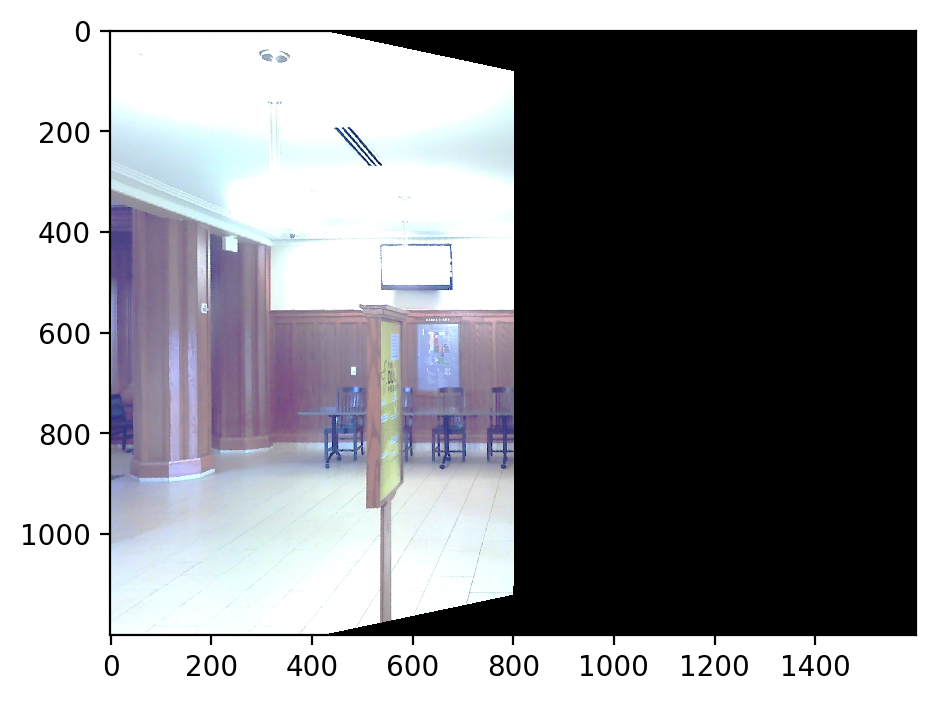

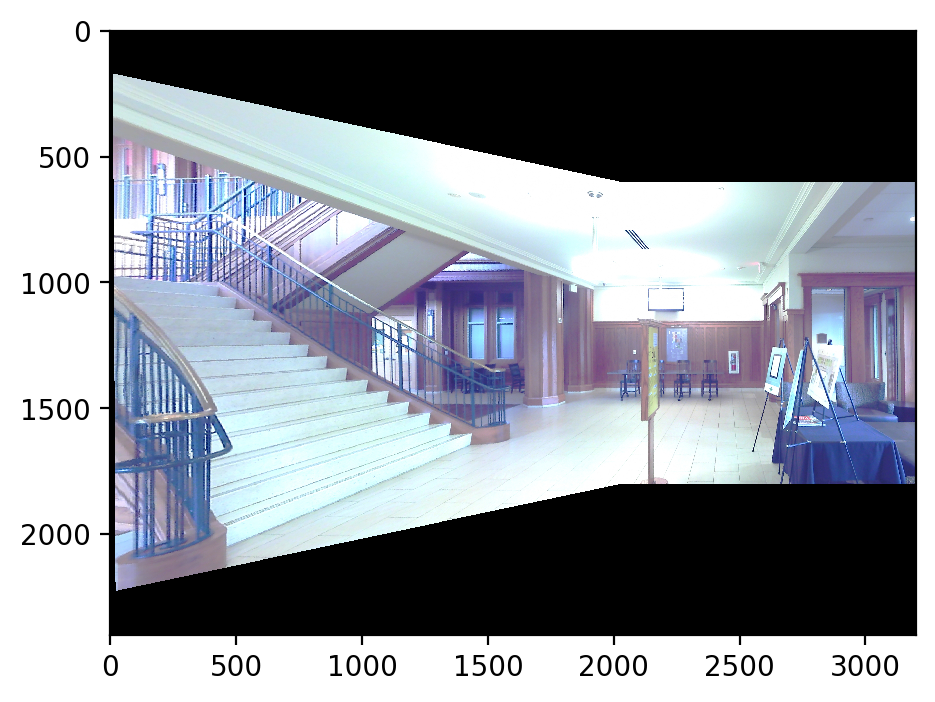

In [57]:
plt.figure(dpi=200)
igs_warp_img = Image.fromarray(igs_warp.astype(np.uint8))
imshow(igs_warp_img)

plt.figure(dpi=200)
igs_merge_img = Image.fromarray(igs_merge.astype(np.uint8))
imshow(igs_merge_img)

In [18]:
# plot images
img_warp = Image.fromarray(igs_warp.astype(np.uint8))
img_merge = Image.fromarray(igs_merge.astype(np.uint8))

# save images
img_warp.save('porto1_warped.png')
img_merge.save('porto1_merged.png')

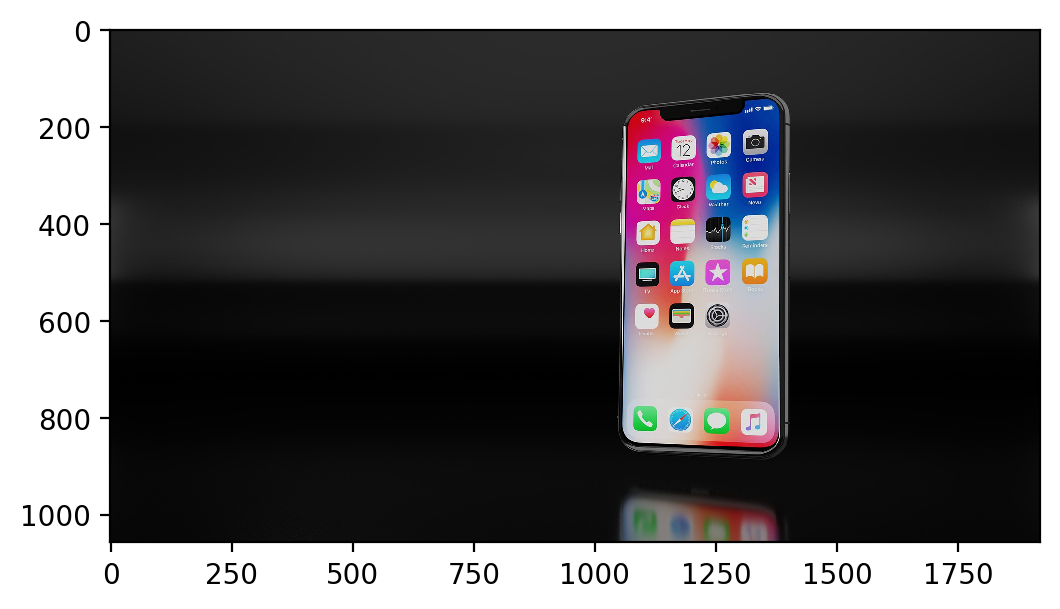

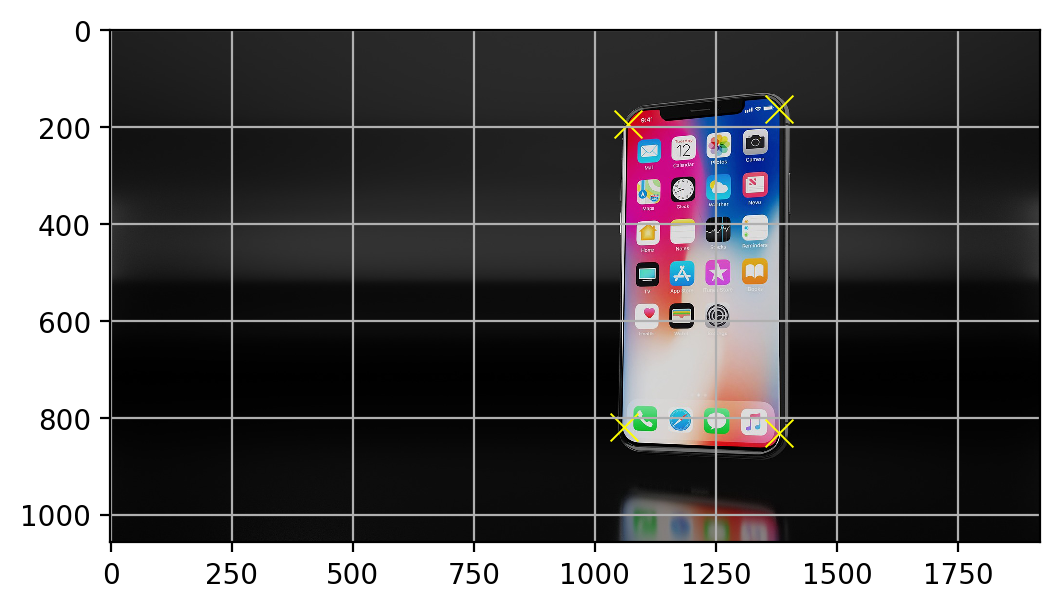

In [62]:
def set_cor_rec():
    # Set corresponding points for rectifying
    c_in = np.array([[1381, 163],
                    [1381, 831],
                    [1061, 820],
                    [1069, 194]])
    
    c_ref = np.array([[1200, 50],
                    [1200, 1000],
                    [700, 1000],
                    [700, 50]])
    
    
    plt.figure(dpi=200)
    plt.grid(True)
    plt.scatter(c_in[:,0], c_in[:,1], marker='x', c='yellow', s=100, linewidth=0.7)
    plt.imshow(igs_rec)
    plt.show()
    
                      
    return c_in, c_ref

##############
# step 2: rectification
##############

img_rec = Image.open('data/iphone.png').convert('RGB')
igs_rec = np.array(img_rec)

plt.figure(dpi=200)
igs_rec = Image.fromarray(igs_rec.astype(np.uint8))
imshow(igs_rec)

c_in, c_ref = set_cor_rec()

In [53]:
def rectify(igs, p1, p2):
    # Rectify
    H = compute_h_norm(p2, p1)
    igs_rec, _ = warp_image(igs, igs, H)

    return igs_rec

igs_rec = rectify(igs_rec, c_in, c_ref)

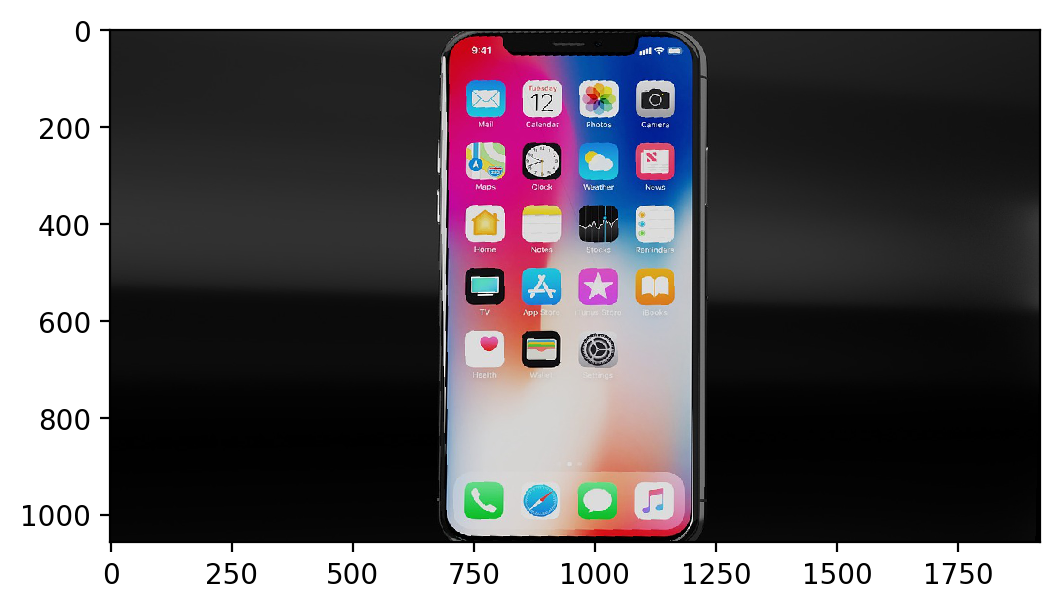

In [54]:
plt.figure(dpi=200)
igs_rec = Image.fromarray(igs_rec.astype(np.uint8))
imshow(igs_rec)

In [55]:
igs_rec.save('iphone_rectified.png')